<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Pr%C3%A9dictions_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Création de la série temporelle expérimentale

Commençons par créer la série temporelle bruitée avec une tendance et une saisonnalitée :

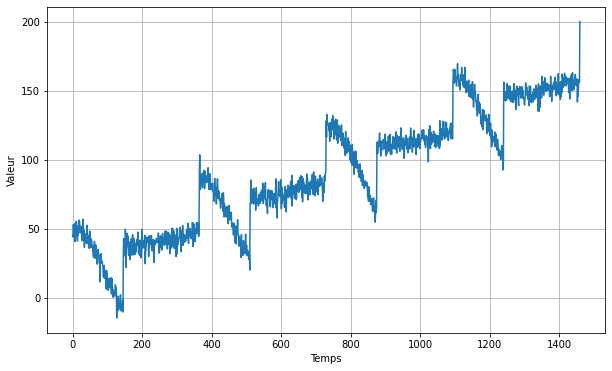

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Fonction permettant d'afficher une série temporelle
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Fonction permettant de créer une tendance
def tendance(temps, pente=0):
    return pente * temps

# Fonction permettant de créer un motif
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

# Fonction permettant de créer une saisonnalité avec un motif
def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

# Création de la série temporelle
temps = np.arange(4 * 365 + 1)            # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
amplitude = 40                            # Amplitude de la la saisonnalité
niveau_bruit = 5                          # Niveau du bruit
offset = 10                               # Offset de la série

serie = offset + tendance(temps, 0.1) + saisonnalite(temps, periode=365, amplitude=amplitude) + bruit_blanc(temps,niveau_bruit)

plt.figure(figsize=(10, 6))
affiche_serie(temps,serie)
plt.show()

Maintenant, mettons en place les intervalles de temps pour l'entrainement et la validation. On sépare tout simplement les données entre t=[0:1000] et t=[1000:1460]. 

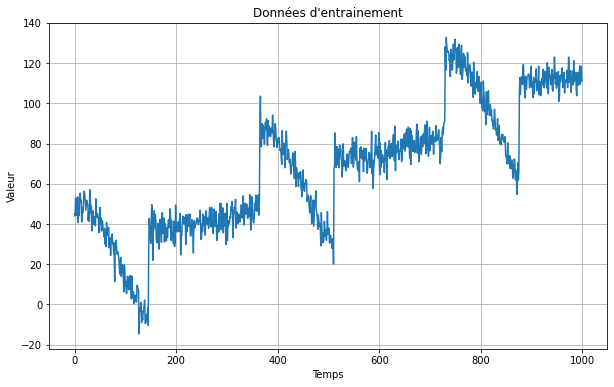

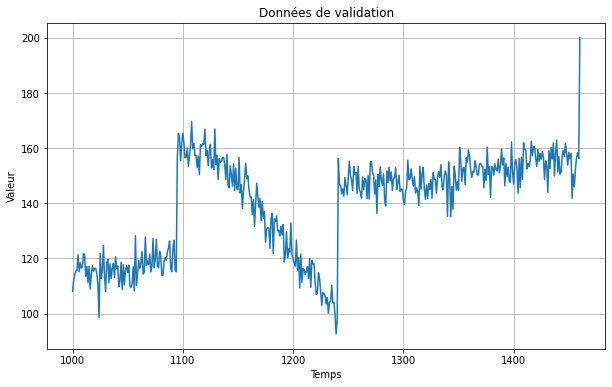

In [3]:
temps_separation = 1000

temps_entrainement = temps[:temps_separation]
x_entrainement = serie[:temps_separation]

temps_validation = temps[temps_separation:]
x_validation = serie[temps_separation:]

plt.figure(figsize=(10, 6))
affiche_serie(temps_entrainement, x_entrainement)
plt.title("Données d'entrainement")
plt.show()

plt.figure(figsize=(10, 6))
affiche_serie(temps_validation, x_validation)
plt.title("Données de validation")
plt.show()

# Prédiction "naïve"

Il s'agit ici de prédire les valeurs en considérant que les valeurs à t=t+1 sont les mêmes qu'à t.

In [4]:
prediciton_naives = serie[temps_separation - 1:-1]

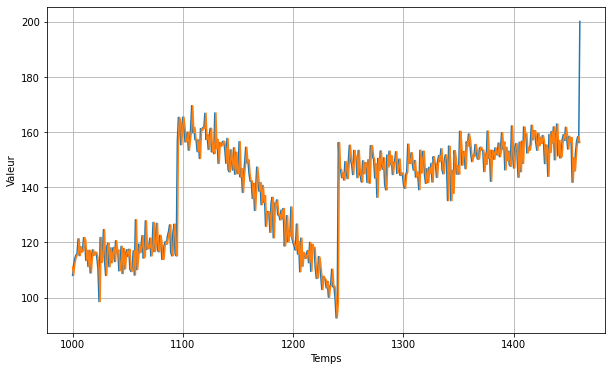

In [6]:
plt.figure(figsize=(10, 6))
affiche_serie(temps_validation, x_validation)
affiche_serie(temps_validation, prediciton_naives)

Faisons un zoom sur la série au début de l'intervalle de validation :

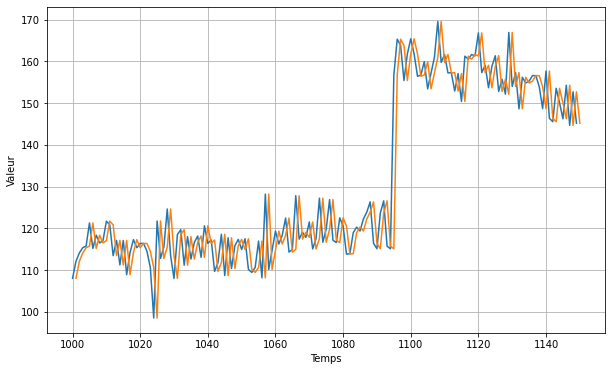

In [7]:
plt.figure(figsize=(10, 6))
affiche_serie(temps_validation, x_validation, debut=0, fin=150)
affiche_serie(temps_validation, prediciton_naives, debut=1, fin=151)

On observe bien que la série prédite se trouve exactement à un pas de temps de la série d'origine.

# Calcul des erreurs sur la prédiction "naïve"

Calculons l'erreur quadratique moyenne et l'erreur absolue moyenne entre les données attendues et les données prédites sur l'intervalle de validation :

In [8]:
print(keras.metrics.mean_squared_error(x_validation, prediciton_naives).numpy())
print(keras.metrics.mean_absolute_error(x_validation, prediciton_naives).numpy())

57.46154899286772
5.501574410241969


# Prédictions par moyenne mobile

Nous allons maintenant essayer de faire des prédictions avec la méthode de la moyenne mobile afin de regarder si on obtient des meilleurs résultats qu'avec la méthode précédente.

Commençons par définir la fonction permettant de calculer la moyenne mobile :

In [13]:
# Fonction permettant de réaliser des prédictions par moyenne mobile
# Si taille_fenetre = 1 alors la prédiction est équivalente à la prédiction "naïve"

def prediction_moyenne_mobile(serie, taille_fenetre):
  prediction = []
  for temps in range(len(serie) - taille_fenetre):
    prediction.append(serie[temps:temps + taille_fenetre].mean())
  return np.array(prediction)

On applique la moyenne mobile avec une fenetre de 30. Les valeurs de la série prédite seront donc le résultat de la moyenne des valeurs sur les 30 instants précédent l'instant t.

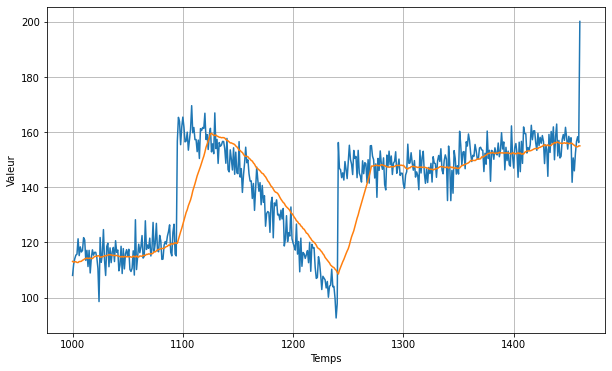

In [15]:
# Applique la moyenne mobile sur la série
moyenne_mobile = prediction_moyenne_mobile(serie, 30)[temps_separation - 30:]

plt.figure(figsize=(10, 6))
affiche_serie(temps_validation, x_validation)
affiche_serie(temps_validation, moyenne_mobile)

# Calcul des erreurs sur la prédiction de la moyenne mobile

In [16]:
print(keras.metrics.mean_squared_error(x_validation, moyenne_mobile).numpy())
print(keras.metrics.mean_absolute_error(x_validation, moyenne_mobile).numpy())

115.88619448307806
7.101195794875073


# Prédictions par moyenne mobile différenciée

L'erreur est plus grande car la moyenne mobile n'anticipe pas la tendance et la saisonnalité. Essayons de les enlever en appliquant la méthode de la différenciation. Comme la période de la saisonnalité est de 365 jours, on choisit de soustraire les valeurs aux instants t – 365 aux valeurs à l'instant t.  
On applique donc la formule : $Serie(t) = Serie(t) - Serie(t-365)$, pour $t>365$

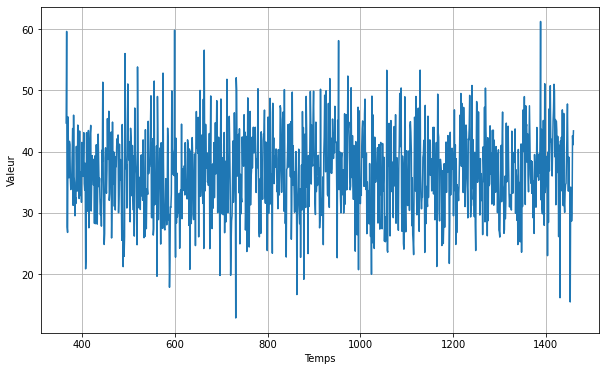

In [18]:
# Serie(t) = Serie(t) - Serie(t-365) pour t>365
serie_differenciee = (serie[365:] - serie[:-365])
temps_differencie = temps[365:]

plt.figure(figsize=(10, 6))
affiche_serie(temps_differencie, serie_differenciee)
plt.show()

On observe que la saisonnalité et la tendance ont été supprimées. Calculons maintenant la moyenne mobile sur ces données avec une fenêtre de 50 :

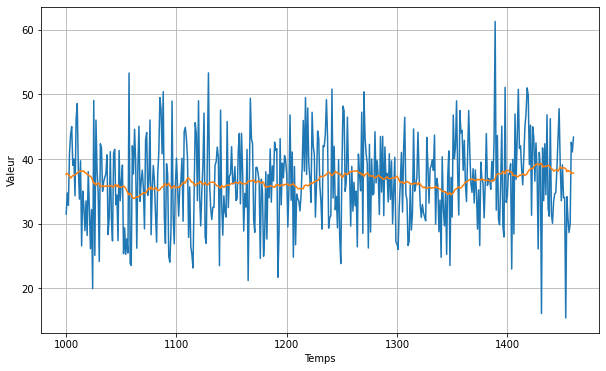

In [21]:
moyenne_mobile_diff = prediction_moyenne_mobile(serie_differenciee, 50)[temps_separation - 365 - 50:]

plt.figure(figsize=(10, 6))
affiche_serie(temps_validation, serie_differenciee[temps_separation - 365:])
affiche_serie(temps_validation, moyenne_mobile_diff)
plt.show()

Ajoutons maintenant les valeurs passées à (t-365) afin de retrouver la tendance et la saisonnalité :

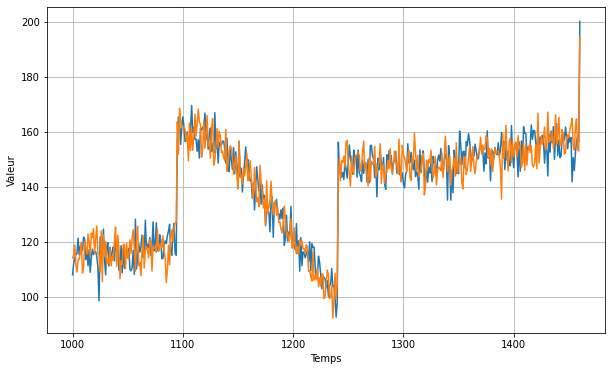

In [22]:
moyenne_mobile_diff_avec_passe = serie[temps_separation - 365:-365] + moyenne_mobile_diff

plt.figure(figsize=(10, 6))
affiche_serie(temps_validation, x_validation)
affiche_serie(temps_validation, moyenne_mobile_diff_avec_passe)
plt.show()

# Calcul des erreurs sur la prédiction de la moyenne mobile différenciée

In [24]:
print(keras.metrics.mean_squared_error(x_validation, moyenne_mobile_diff_avec_passe).numpy())
print(keras.metrics.mean_absolute_error(x_validation, moyenne_mobile_diff_avec_passe).numpy())

46.450264327065405
5.465951221358361


# Suppression du bruit sur les données passées

On obtient des résultats supérieurs à la méthode naïve. Cependant, les prédictions sont encore bruitées parce que nous avons ajouté les données passées qui sont bruitées.  
Appliquons une moyenne mobile sur les données passées avec une fenêtre de 10 pour supprimer davantage de bruit :

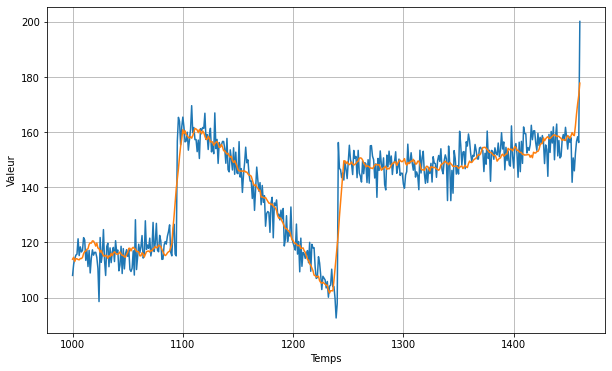

In [27]:
moyenne_mobile_diff_avec_passe_sans_bruit = prediction_moyenne_mobile(serie[temps_separation - 370:-360], 10) + moyenne_mobile_diff

plt.figure(figsize=(10, 6))
affiche_serie(temps_validation, x_validation)
affiche_serie(temps_validation, moyenne_mobile_diff_avec_passe_sans_bruit)
plt.show()

# Calcul des erreurs sur la prédiction finale

In [29]:
print(keras.metrics.mean_squared_error(x_validation, moyenne_mobile_diff_avec_passe_sans_bruit).numpy())
print(keras.metrics.mean_absolute_error(x_validation, moyenne_mobile_diff_avec_passe_sans_bruit).numpy())

36.27104106283883
4.378177665720013
